In [1]:
import sys  
sys.path.insert(0, "../src")

import numpy as np
import time
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ddnnf import dDNNF
from sklearn.metrics import ndcg_score
from scipy.special import comb
from approximation_algorithms import shap_approximate
from approximation_algorithms import cnf_prior_shap_approximate
from approximation_algorithms import monte_carlo_approximate
from approximation_algorithms import cnf_prior_monte_carlo_approximate
from approximation_algorithms import cheats_monte_carlo_approximate
from approximation_algorithms import cnf_prior_approximation

import warnings
warnings.filterwarnings('ignore')

In [2]:
def shapley_dict_to_list(shapley_values):
    shapley_values = sorted(shapley_values.items(), key=lambda x: x[0])
    return np.array([x[1] for x in shapley_values])

def l1(true, approx):
    return np.abs(shapley_dict_to_list(true) - shapley_dict_to_list(approx)).sum()

def l2(true, approx):
    return ((shapley_dict_to_list(true) - shapley_dict_to_list(approx))**2).sum()

def l1_at_k(true, approx, k):
    true = shapley_dict_to_list(true)
    approx = shapley_dict_to_list(approx)
    idxs = true.argsort()[-k:]
    return np.abs(true[idxs] - approx[idxs]).sum()

def l2_at_k(true, approx, k):
    true = shapley_dict_to_list(true)
    approx = shapley_dict_to_list(approx)
    idxs = true.argsort()[-k:]
    return ((true[idxs] - approx[idxs])**2).sum()

def get_top_k_idxs_with_ties(a, k):
    if k >= len(a):
        return np.array((range(len(a))))
    idxs_srt = a.argsort()
    i = k
    v = a[idxs_srt[-i]]
    while i < len(a) and a[idxs_srt[-i]]==v:
        i+=1
    if a[idxs_srt[-i]]!=v:
        return idxs_srt[-(i-1):]
    else:
        return np.array((range(len(a))))

def precision_at_k(true, approx, k):
    true = shapley_dict_to_list(true)
    approx = shapley_dict_to_list(approx)
    # Handle ties
    true_idxs = get_top_k_idxs_with_ties(true, k)
    approx_idxs = approx.argsort()[-k:]
    return len(set(approx_idxs).intersection(set(true_idxs)))/k

def ndcg(true, approx, k=None):
    return ndcg_score([shapley_dict_to_list(true)], [shapley_dict_to_list(approx)], k=k)

In [3]:
def process_circuit(circuit_runtime, samples_fracs, algs):
    circuit_fname = circuit_runtime['circuit_fname']
    
    cur_output = {
        "tuple": circuit_runtime['tuple'],
        "circuit_fname": circuit_runtime['circuit_fname'],
        "provenance_hash": circuit_runtime['provenance_hash'],
        "cnf_n_variables": circuit_runtime['cnf_n_variables'],
        "cnf_n_clauses": circuit_runtime['cnf_n_clauses']
    }
    
    if circuit_runtime['comilation_status'] == 'Success' and circuit_runtime['shapley_status'] == 'Success':
        
        cur_output["nnf_n_nodes"] = circuit_runtime['nnf_n_nodes']
        cur_output["nnf_n_edges"] = circuit_runtime['nnf_n_edges']
        cur_output["nnf_n_variables"] = circuit_runtime['nnf_n_variables']
        cur_output["n_forget_gates"] = circuit_runtime['n_forget_gates']
        
        nnf_fname = circuit_fname + '.nnf'
        gates_fname = circuit_fname + '_gate'

        ddnnf = dDNNF(nnf_fname, gates_fname)
        n = ddnnf.n_vars()
        
        samples_outputs = []
        cur_output['samples_outputs'] = samples_outputs
        
        true_shapley_values = circuit_runtime['shapley_values']
            
        for sample_frac in samples_fracs:
            nsamples = int(np.ceil(n * sample_frac))
            
            cur_sample_output = {'sample_frac': int(sample_frac),
                                 'nsamples': nsamples}
            
            for alg in algs:
                alg_func = algs[alg]['func']
                alg_args = algs[alg]['args'] if 'args' in algs[alg] else {}
                require_circuit_runtime = 'circuit_runtime' in algs[alg]

                start = time.time()
                if not require_circuit_runtime:
                    values = alg_func(ddnnf, nsamples, **alg_args)
                else:
                    values = alg_func(circuit_runtime, ddnnf, nsamples, **alg_args)
                end = time.time()
                values = {str(var): value for var, value in values.items()}
                cur_sample_output[alg + ' execution_time'] = (end - start)
                cur_sample_output[alg + ' values'] = values
                cur_sample_output[alg + ' l1'] = l1(true_shapley_values, values)
                cur_sample_output[alg + ' l2'] = l2(true_shapley_values, values)
                cur_sample_output[alg + ' nDCG'] = ndcg(true_shapley_values, values)
                for k in [1, 3, 5, 10]:
                    cur_sample_output[alg + ' l1@' + str(k)] = l1_at_k(true_shapley_values, values, k)
                    cur_sample_output[alg + ' l2@' + str(k)] = l2_at_k(true_shapley_values, values, k)
                    cur_sample_output[alg + ' precision@' + str(k)] = precision_at_k(true_shapley_values, values, k)
                    cur_sample_output[alg + ' nDCG@' + str(k)] = ndcg(true_shapley_values, values, k)
            samples_outputs.append(cur_sample_output)
            
        cur_output['Status'] = 'Success'    
    else:
        cur_output['Status'] = 'Skipped'
    
    return cur_output

In [4]:
circuits_home = Path('../circuits')
outputs_home = Path('../outputs')

samples_fracs = [1, 10, 20, 30, 40, 50]

outputs = []

algs = {
    'SHAP': {
        'func': shap_approximate
    },
    'SHAP (CNF proxy@10)': {
        'func': cnf_prior_shap_approximate,
        'circuit_runtime': True
    },
    'MC': {
        'func': monte_carlo_approximate
    },
    'MC (CNF proxy@10)': {
        'func': cnf_prior_monte_carlo_approximate,
        'circuit_runtime': True
    },
    'MC (Cheats@10)': {
        'func': cheats_monte_carlo_approximate,
        'circuit_runtime': True
    },
    'CNF proxy': {
        'func': cnf_prior_approximation,
        'circuit_runtime': True
    }
}

for db_home in outputs_home.iterdir():
    if db_home.is_dir():
        db = db_home.stem
        
        if db not in ["imdb", "tpch"]:
            continue
        
        print('Start processing queries from ' + db)
            
        for output_path in db_home.iterdir():
            print('\tWorking on ' + output_path.stem)
            
            runtime_fname = output_path/"runtime.json"
            
            if runtime_fname.exists():
                with open(runtime_fname, 'r') as f:
                    runtime = json.load(f)
                
                approximation = []
                for circuit_runtime in tqdm(runtime['query_outputs']):
                    cur_output = process_circuit(circuit_runtime, samples_fracs, algs)
                    outputs.append(cur_output)

## Convert outputs to dataframe

In [5]:
global_columns = ["cnf_n_variables", "cnf_n_clauses", "nnf_n_nodes", "nnf_n_edges"]
sample_columns = ["sample_frac", "nsamples"]
for alg in algs:
    sample_columns.append(alg+ ' execution_time')
    sample_columns.append(alg+ ' l1')
    sample_columns.append(alg+ ' l2')
    sample_columns.append(alg+ ' nDCG')
    for m in ['l1', 'l2', 'precision', 'nDCG']:
        for k in [1, 3, 5, 10]:
            sample_columns.append(alg+ ' ' + m + "@" + str(k))

data = {"Query": [],
        "#Tuples": []}
for c in global_columns:
    data[c] = []
for c in sample_columns:
    data[c] = []
    
for approx in outputs:
    if approx["Status"] == "Success":
        circuit_path = Path(approx["circuit_fname"])
        db = circuit_path.parts[-3]
        query = circuit_path.parts[-2]
        
        if db in ["tpch", "imdb"]:
            for sample in approx["samples_outputs"]:
                for c in global_columns:
                    data[c].append(approx[c])
                for c in sample_columns:
                    data[c].append(sample[c])
                data["Query"].append(query)
                data["#Tuples"].append(len(approx["samples_outputs"][0]["SHAP values"]))
            
df = pd.DataFrame(data)
df

,Query,#Tuples,cnf_n_variables,cnf_n_clauses,nnf_n_nodes,nnf_n_edges,sample_frac,nsamples,SHAP execution_time,SHAP l1,...,CNF proxy l2@5,CNF proxy l2@10,CNF proxy precision@1,CNF proxy precision@3,CNF proxy precision@5,CNF proxy precision@10,CNF proxy nDCG@1,CNF proxy nDCG@3,CNF proxy nDCG@5,CNF proxy nDCG@10
0,7,82,103,162,616,973,1,82,0.208117,0.705087,...,0.111554,0.111728,1.0,1.0,0.6,0.3,1.0,1.0,1.0,1.0
1,7,82,103,162,616,973,10,820,1.637298,0.410654,...,0.111554,0.111728,1.0,1.0,0.6,0.3,1.0,1.0,1.0,1.0
2,7,82,103,162,616,973,20,1640,3.171652,0.267616,...,0.111554,0.111728,1.0,1.0,0.6,0.3,1.0,1.0,1.0,1.0
3,7,82,103,162,616,973,30,2460,4.193412,0.289862,...,0.111554,0.111728,1.0,1.0,0.6,0.3,1.0,1.0,1.0,1.0
4,7,82,103,162,616,973,40,3280,5.498000,0.245153,...,0.111554,0.111728,1.0,1.0,0.6,0.3,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198745,8d,16,27,92,192,349,10,160,0.078993,0.313597,...,0.028617,0.032717,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
198746,8d,16,27,92,192,349,20,320,0.134925,0.179419,...,0.028617,0.032717,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
198747,8d,16,27,92,192,349,30,480,0.205835,0.169938,...,0.028617,0.032717,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
198748,8d,16,27,92,192,349,40,640,0.266520,0.222743,...,0.028617,0.032717,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Metrics as dunction of sampling budget

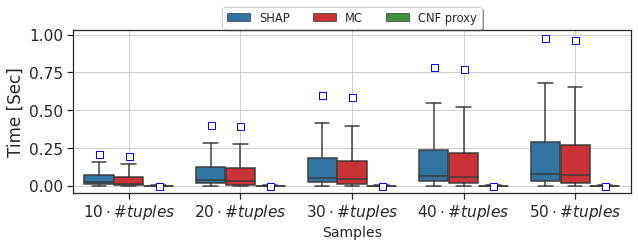

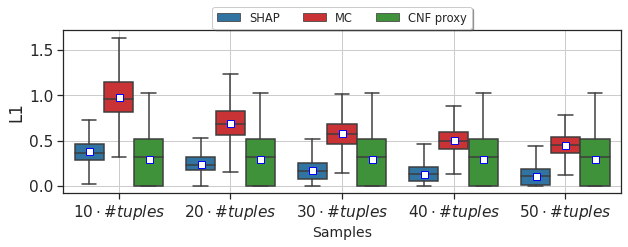

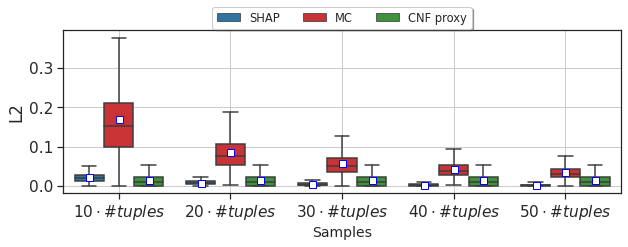

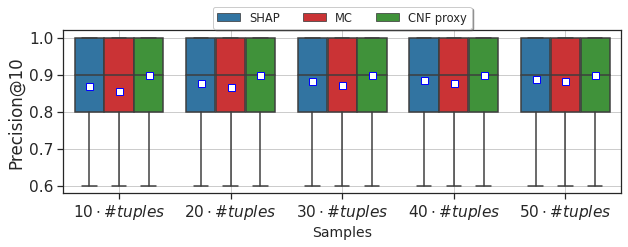

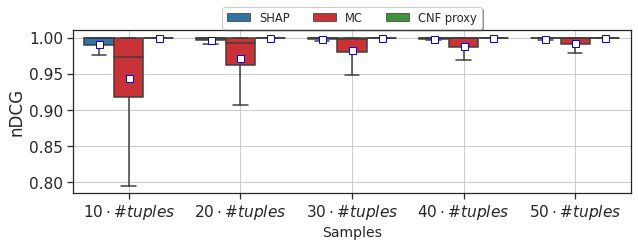

In [6]:
palette = sns.color_palette("Paired")
alg2color = {
    "SHAP": palette[1],
    "SHAP (CNF proxy@10)": palette[0],
    "MC": palette[5],
    "MC (CNF proxy@10)": palette[4],
    "MC (Cheats@10)": palette[6],
    "CNF proxy": palette[3]
}


def plot_by_param(df, param, algs, ylabel=None):   
    a = pd.melt(df, id_vars=["sample_frac"], value_vars=[alg + param for alg in algs])
    
    sns.set(font_scale = 1.4, context='notebook', style='ticks')
    if len(algs) < 4:
        plt.figure(figsize=(10,3))
    else:
        plt.figure(figsize=(14,3))
    
    g = sns.boxplot(data=a[a["sample_frac"]>1], x="sample_frac", y="value", hue="variable",
                    palette=[alg2color[alg] for alg in algs],
                    showmeans=True, showfliers=False,
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":7})
    g.axes.set_xlabel("Samples", fontsize=14)
    g.axes.set_xticklabels([r"$%s \cdot \# tuples$" % x for x in [10, 20, 30 ,40 ,50]])
    g.axes.set_ylabel(param.strip() if ylabel is None else ylabel)
    handles, labels = g.get_legend_handles_labels()
    g.legend(handles, [" ".join(l.split()[:-1]) for l in labels],
             loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=6, fancybox=True, shadow=True, fontsize=11.5)
    
    plt.grid(True)
    plt.show()


plot_by_param(df, ' execution_time', ["SHAP", "MC", "CNF proxy"], "Time [Sec]")
plot_by_param(df, ' l1', ["SHAP", "MC", "CNF proxy"], "L1")
plot_by_param(df, ' l2', ["SHAP", "MC", "CNF proxy"], "L2")
plot_by_param(df, ' precision@10', ["SHAP", "MC", "CNF proxy"], "Precision@10")
plot_by_param(df, ' nDCG', ["SHAP", "MC", "CNF proxy"])

## CNF Proxy metrics as function of procenance size

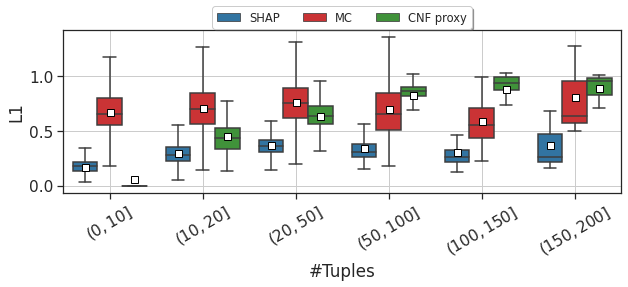

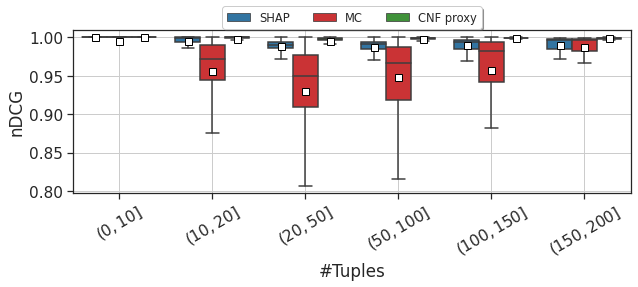

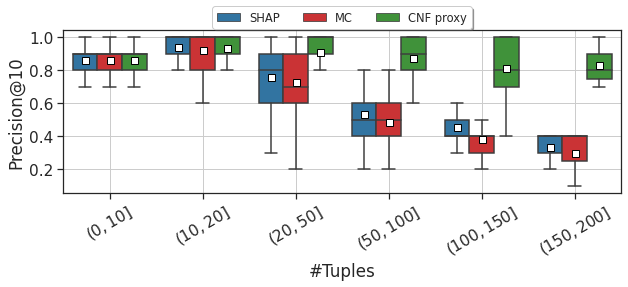

In [7]:
def plot_multi_algs_by_param(df, algs, param, ylabel=None):
    sns.set(font_scale = 1.4, context='notebook', style='ticks')
    if len(algs) < 4:
        plt.figure(figsize=(10,3))
    else:
        plt.figure(figsize=(14,3))    
    
    col = "#Tuples"
    cols = ["Query", col]
    for alg in algs:
        cols.append(alg + ' ' + param)
    d = df[df["sample_frac"]==20][cols]

    da = pd.melt(d, id_vars=["Query", col], value_name=param)

    da.loc[:, col] = pd.cut(da[col], bins=[0, 10, 20, 50, 100, 150, 200],
                            labels=[r'$(0,10]$', r'$(10, 20]$', r'$(20,50]$', r'$(50,100]$', r'$(100, 150]$', r'$(150, 200]$'],
                            duplicates="drop")

    ax = sns.boxplot(x=col, y=param, data=da, showfliers=False, hue="variable",
                     palette=[palette[i] for i in [1, 5, 3]],
                     showmeans=True, meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":7})

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [" ".join(l.split()[:-1]) for l in labels],
             loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=6, fancybox=True, shadow=True, fontsize=11.5)
    
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    if ylabel is not None:
        ax.axes.set_ylabel(ylabel)
    plt.grid(True)
    plt.show()
    
plot_multi_algs_by_param(df, ["SHAP", "MC", "CNF proxy"], 'l1', "L1")
plot_multi_algs_by_param(df, ["SHAP", "MC", "CNF proxy"], 'nDCG')
plot_multi_algs_by_param(df, ["SHAP", "MC", "CNF proxy"], 'precision@10', "Precision@10")    